In [5]:
# Install required package
import sys
!{sys.executable} -m pip install --user --upgrade steam-nb-api

import os
import csv
from pathlib import Path
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from copy import *
from steam_nb_api.ledet.ParametersLEDET import ParametersLEDET
from steam_nb_api.utils import misc
from steam_nb_api.roxie_parser import MagneticCoil
from steam_nb_api.utils.SelfMutualInductanceCalculation import SelfMutualInductanceCalculation

from steam_nb_api.roxie_parser import CableDatabase
from steam_nb_api.roxie_parser import ConductorPosition
from steam_nb_api.roxie_parser.geometricFunctions import close_pairs_ckdtree, close_pairs_pdist

Requirement already up-to-date: steam-nb-api in /eos/home-l/lbender/.local/lib/python3.7/site-packages (0.3.420)


# Global variables

In [6]:
nameMagnet = 'MCBV_1AP'

# Define style for plots
selectedFont = {'fontname':'DejaVu Sans', 'size':14}

# If this variable is set to True, many comments will be displayed
verbose = False

# Load default LEDET variable descriptions
paramLEDET_notebook = ParametersLEDET()

# Generate magnet geometry parsing .data and .cadata files

MCBV_1AP_All_WithIron_WithSelfField.data



<IPython.core.display.Javascript object>


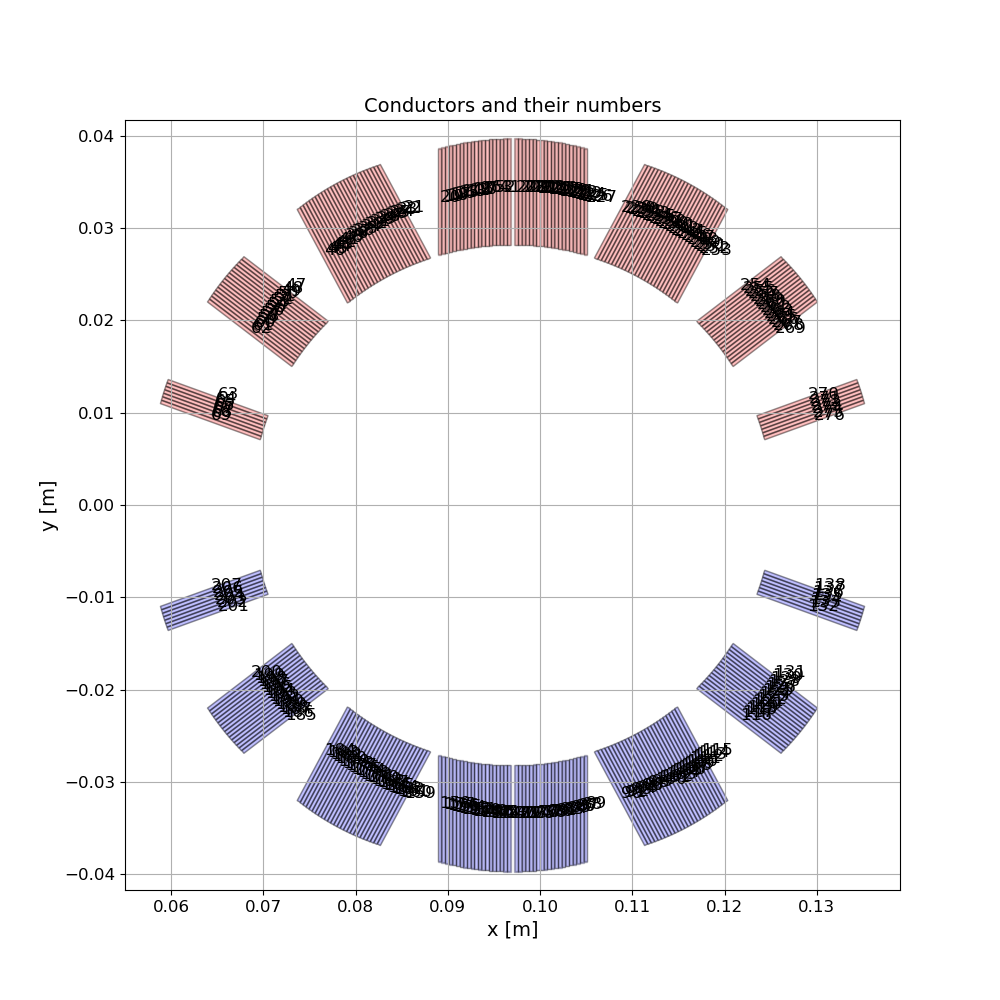

In [7]:
# Select ROXIE .cadata file with conductor data
currentDirectory = Path(os.path.split(os.getcwd())[0])
fileNameCadata = os.path.join(currentDirectory,'resources','roxie.cadata')
fileName = nameMagnet + '_All_WithIron_WithSelfField.map2d'
fileNameData = nameMagnet + '_All_WithIron_WithSelfField.data'

print(fileNameData)
    
# Define the magnetic coil
definedMagneticCoil = MagneticCoil.MagneticCoil()
xPos, yPos, iPos, xBarePos, yBarePos, xS, yS, iS = definedMagneticCoil.generateCoilGeometry(fileNameData, fileNameCadata, verbose=verbose)
# Plot conductors and their numbers
f = plt.figure(2, figsize=(10, 10))
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

    # Plot conductor numbers
    x_ave_cond, y_ave_cond = sum(cXPos) / len(cXPos), sum(cYPos) / len(cYPos)
    plt.text(x_ave_cond, y_ave_cond, '{}'.format(c + 1))

# Plot edges of bare conductors
for c, (cXBarePos, cYBarePos) in enumerate(zip(xBarePos, yBarePos)):
    pt1, pt2, pt3, pt4 = (cXBarePos[0], cYBarePos[0]), (cXBarePos[1], cYBarePos[1]), (cXBarePos[2], cYBarePos[2]), (
    cXBarePos[3], cYBarePos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Conductors and their numbers', **selectedFont)
plt.set_cmap('jet')
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.grid()

In [8]:
RibbonCable = True
# Array, that defines each group--> [No. of Layers, Ribbons per Group]
GeoArr = [[25,20],[25,26],[25,16],[25,7]]*4

if RibbonCable:
    # Read file
    newFileName = nameMagnet + '_ROXIE_All_WithIron_WithSelfField.map2d'
    if not os.path.isfile(newFileName):
        os.rename(fileName, newFileName)
    file = open(newFileName, "r")
    fileContent = file.read()

    # Separate rows
    fileContentByRow = fileContent.split("\n")
    NewMap2d = np.array([[ None for x in range(10)] 
                 for y in range(2,len(fileContentByRow)-1)])
    # Reorder Entries according to GeoArr and Type Ribbon Cable
    CondCounter = 0
    for k in range(len(GeoArr)):
        for j in range(GeoArr[k][0]):
            for i in range(GeoArr[k][1]):
                fc = fileContentByRow[j+i*GeoArr[k][0]+2+CondCounter]
                NewMap2d[i+j*GeoArr[k][1]+CondCounter,:]=fc.split()
                NewMap2d[i+j*GeoArr[k][1]+CondCounter,0]=j+k*GeoArr[k][0]+1
        CondCounter = CondCounter + GeoArr[k][0]*GeoArr[k][1]

    # Write new .map2d File
    mat = np.matrix(NewMap2d)
    head = np.array(fileContentByRow[0].split()).transpose()
    head_merge = np.array([ None for x in range(10)])
    for i in range(head_merge.shape[0]-1):
        head_merge[i]=head[i]
    head_merge[9] = head[9]+" "+head[10]
    mat = mat.astype(float)
    CondNumbers  = np.array([np.linspace(1,len(fileContentByRow)-3,len(fileContentByRow)-3).astype(int)]).transpose()
    mat[:,2] = CondNumbers
    mat[:,1] = mat[:,2]
    with open(nameMagnet + '_All_WithIron_WithSelfField.map2d','wb') as f:
        np.savetxt(f,np.array([head_merge]), fmt="%s")
        np.savetxt(f,[""],fmt="%s")
        for row in mat:
            np.savetxt(f,row, fmt=["%i","%i","%i","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f"])
            
#     ## Repeat for NoIron file - for consistency
#     fileName = nameMagnet + '_All_NoIron_NoSelfField.map2d'
#     newFileName = nameMagnet + '_ROXIE_All_NoIron_NoSelfField.map2d'
#     if not os.path.isfile(newFileName):
#         os.rename(fileName, newFileName)
#     # Read file
#     file = open(newFileName, "r")
#     fileContent = file.read()

#     # Separate rows
#     fileContentByRow = fileContent.split("\n")
#     NewMap2d = np.array([[ None for x in range(10)] 
#                  for y in range(2,len(fileContentByRow)-1)])
#     # Reorder Entries according to GeoArr and Type Ribbon Cable
#     CondCounter = 0
#     for k in range(len(GeoArr)):
#         for j in range(GeoArr[k][0]):
#             for i in range(GeoArr[k][1]):
#                 fc = fileContentByRow[j+i*GeoArr[k][0]+2+CondCounter]
#                 NewMap2d[i+j*GeoArr[k][1]+CondCounter,:]=fc.split()
#                 NewMap2d[i+j*GeoArr[k][1]+CondCounter,0]=j+k*GeoArr[k][0]+1
#         CondCounter = CondCounter + GeoArr[k][0]*GeoArr[k][1]

#     # Write new .map2d File
#     mat = np.matrix(NewMap2d)
#     head = np.array(fileContentByRow[0].split()).transpose()
#     head_merge = np.array([ None for x in range(10)])
#     for i in range(head_merge.shape[0]-1):
#         head_merge[i]=head[i]
#     head_merge[9] = head[9]+" "+head[10]
#     mat = mat.astype(float)
#     CondNumbers  = np.array([np.linspace(1,len(fileContentByRow)-3,len(fileContentByRow)-3).astype(int)]).transpose()
#     mat[:,2] = CondNumbers
#     mat[:,1] = mat[:,2]
#     with open(nameMagnet + '_All_NoIron_NoSelfField.map2d','wb') as f:
#         np.savetxt(f,np.array([head_merge]), fmt="%s")
#         np.savetxt(f,[""],fmt="%s")
#         for row in mat:
#             np.savetxt(f,row, fmt=["%i","%i","%i","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f","%.4f"])

# Field maps from ROXIE

Total number of strands in the field-map from ROXIE = 6900
Peak magnetic field in the field-map from ROXIE = 3.1837699665647956 T


<IPython.core.display.Javascript object>


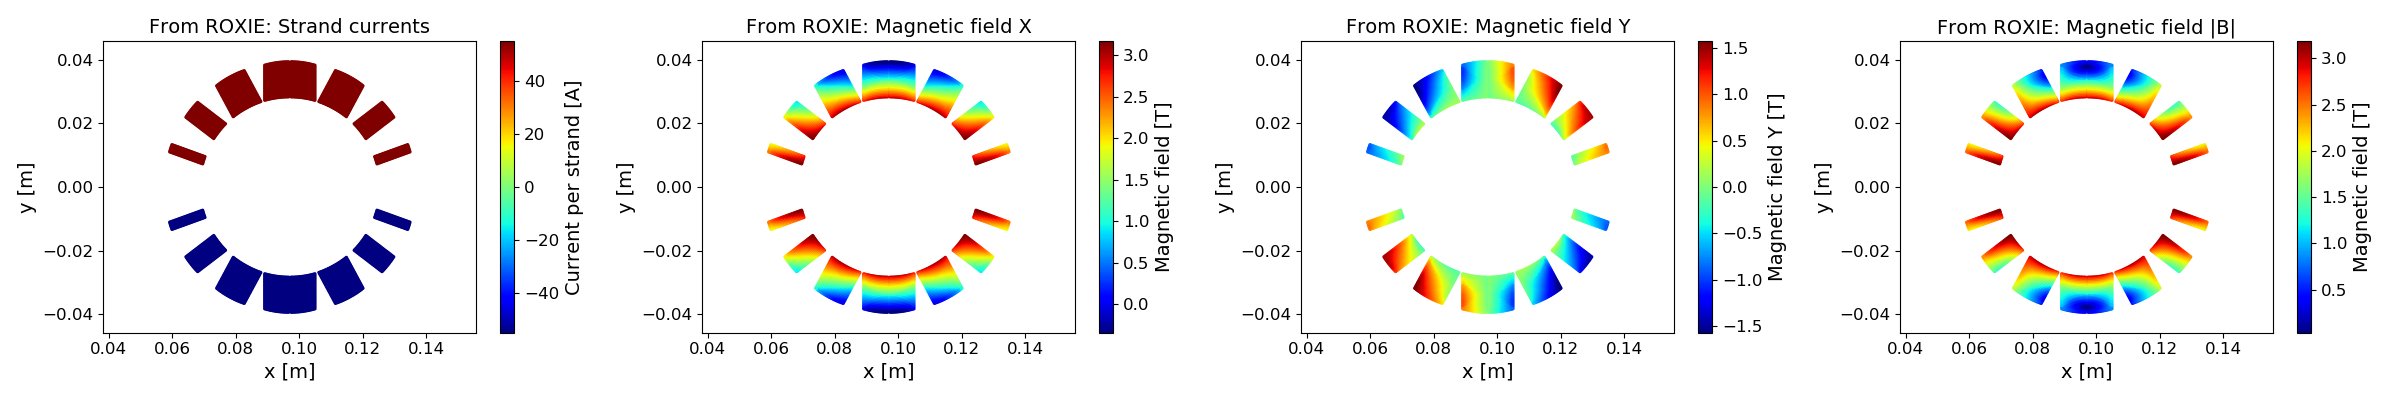

In [9]:
# Acquire data from ROXIE .map2d file
fileName = nameMagnet + '_All_WithIron_WithSelfField.map2d'
headerLines = 1

strandToGroup = np.array([])
strandToHalfTurn = np.array([])
idx = []
x = []
y = []
Bx = []
By = []
Area = []
I = []
fillFactor = []

# Read file
file = open(fileName, "r")
fileContent = file.read()

# Separate rows
fileContentByRow = fileContent.split("\n")

for index in range(len(fileContentByRow)-1):
    if index>headerLines:
        fc = fileContentByRow[index]
        row = fc.split()
        strandToGroup = np.hstack([strandToGroup,int(row[0])])
        strandToHalfTurn = np.hstack([strandToHalfTurn,int(row[1])])
        idx = np.hstack([idx,float(row[2])])
        x = np.hstack([x,float(row[3])/1000]) # in [m]
        y = np.hstack([y,float(row[4])/1000]) # in [m]
        Bx = np.hstack([Bx,float(row[5])])
        By = np.hstack([By,float(row[6])])
        Area = np.hstack([Area,float(row[7])])
        I = np.hstack([I,float(row[8])])
        fillFactor = np.hstack([fillFactor,float(row[9])])
        
[_,c] = np.unique(strandToHalfTurn,return_index=True)
[_,nT] = np.unique(strandToGroup[c],return_counts=True)

nStrandsFieldMap = len(strandToGroup)
print('Total number of strands in the field-map from ROXIE = {}'.format(nStrandsFieldMap))

# Calculate absolute magnetic field
B = []
for i in range(nStrandsFieldMap):
    B = np.hstack([B, (Bx[i]**2+By[i]**2)**.5 ])
print('Peak magnetic field in the field-map from ROXIE = {} T'.format(np.max(B)))

# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=I)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Strand currents',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Current per strand [A]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=Bx)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field X',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=By)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field Y',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field Y [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=B)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field |B|',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

<IPython.core.display.Javascript object>


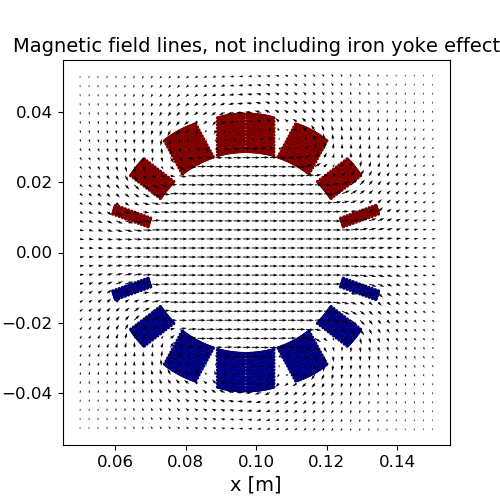

(0.045000000000000005, 0.155, -0.05500000000000001, 0.05500000000000001)

In [10]:
minMaxX = [0.05, 0.15] # to adjust depending on the coil dimensions
minMaxY = [-0.05, 0.05] # to adjust depending on the coil dimensions
nGridPoints=[40, 40]
Bx_map, By_map, B_map, x_map, y_map = definedMagneticCoil.calculateMagneticFieldGrid(minMaxX, minMaxY, nGridPoints)

# Plot current lines
f = plt.figure(figsize=(5, 5))
plt.scatter(xS, yS, s=2, c=iS)
# Plot magnetic field arrows
q = plt.quiver(x_map, y_map, Bx_map, By_map, color='k')
plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Magnetic field lines, not including iron yoke effect', **selectedFont)
plt.set_cmap('jet')
# cbar = plt.colorbar()
# cbar.set_label('Magnetic field [T]', **selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Manipulate imported strand positions

Total number of strands = 6900
Total number of half-turns = 6900
Total number of turns = 3450
Total number of groups = 400


<IPython.core.display.Javascript object>


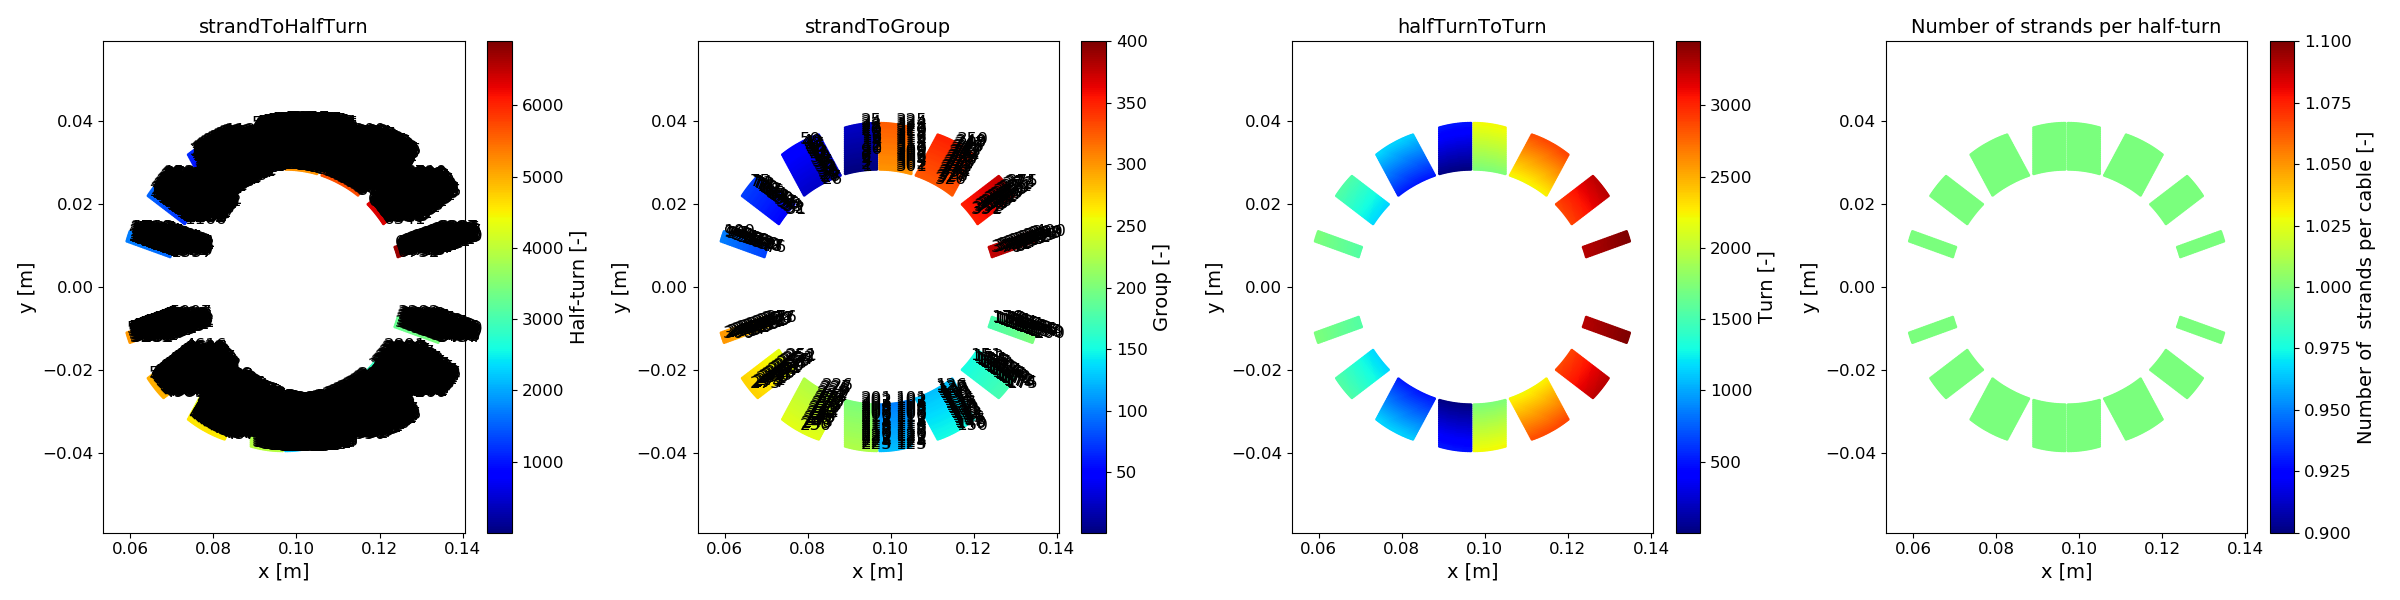

In [11]:
# Number of strands in each half-turn
nStrands = len(strandToGroup)
polarities = np.sign(I);
nHalfTurns = int(np.max(strandToHalfTurn));
nTurns = int(nHalfTurns/2)
nGroups = int(np.max(strandToGroup));
nS = []
for ht in range(1,nHalfTurns+1):
    #nS =sum(strandToHalfTurn==ht);
    nS = np.hstack([ nS, np.size(np.where(strandToHalfTurn==ht)) ]) # Number of strands in each half-turn
nS = np.int_(nS)

strandToGroup = np.int_(strandToGroup)
strandToHalfTurn = np.int_(strandToHalfTurn)
halfTurnToTurn=np.tile(np.arange(1,nTurns+1),2);

# Average half-turn positions
x_ave = []
y_ave = []
for ht in range(1,nHalfTurns+1):
    x_ave = np.hstack([ x_ave, np.mean( x[np.where(strandToHalfTurn==ht)] )])
    y_ave = np.hstack([ y_ave, np.mean( y[np.where(strandToHalfTurn==ht)] )])

# Average group positions
x_ave_group = []
y_ave_group = []
for g in range(1,nGroups+1):
    x_ave_group = np.hstack([ x_ave_group, np.mean( x[np.where(strandToGroup==g)] )])
    y_ave_group = np.hstack([ y_ave_group, np.mean( y[np.where(strandToGroup==g)] )])
    
print('Total number of strands = ' + str(nStrands))
print('Total number of half-turns = ' + str(nHalfTurns))
print('Total number of turns = ' + str(nTurns))
print('Total number of groups = ' + str(nGroups))


# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,6))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=strandToHalfTurn)
for ht in range(nHalfTurns):
    plt.text(x_ave[ht], y_ave[ht], '{}'.format(ht + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToHalfTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Half-turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=strandToGroup)
for g in range(nGroups):
    plt.text(x_ave_group[g], y_ave_group[g], '{}'.format(g + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x_ave, y_ave, s=2, c=halfTurnToTurn)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('halfTurnToTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Number of strands per half-turn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Number of  strands per cable [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

# Overall magnet variables

In [12]:
T00 = 1.9
l_magnet = 0.647
I00  = 1375/25
Iref = 1375/25

# Definition of groups of conductors

1 coil sections defined.
400 groups defined.


<IPython.core.display.Javascript object>


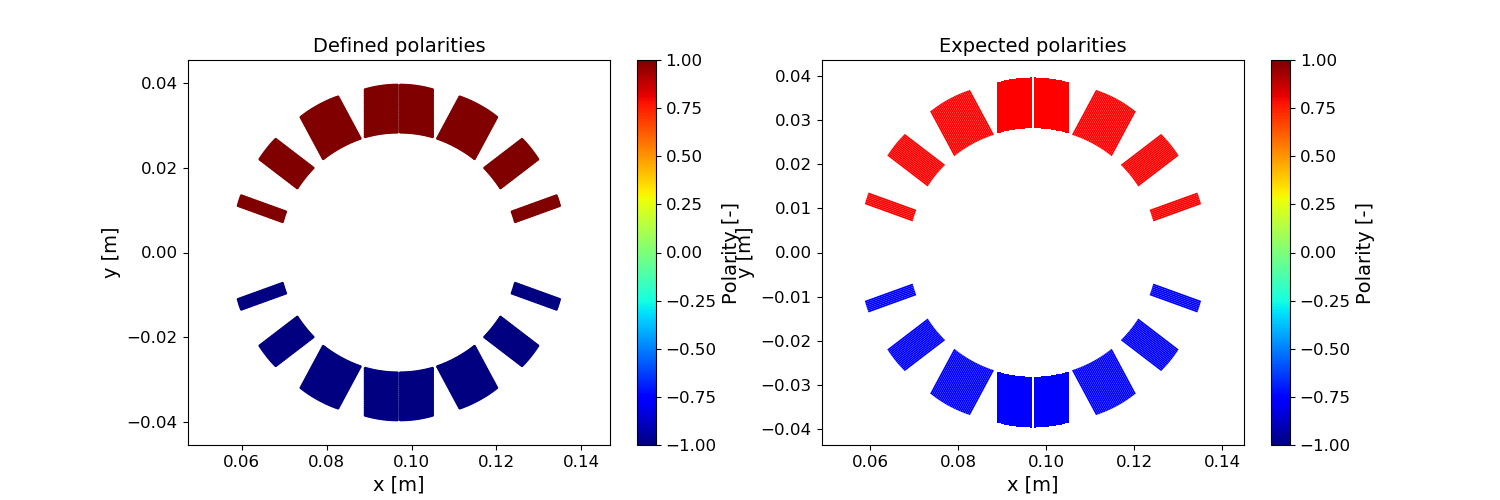

(0.054994993597030806,
 0.1390050064029692,
 -0.04371047121642589,
 0.04371047121642589)

In [13]:
GroupToCoilSection = int(nGroups) * [1]
polarities_inGroup = 100*[1] + 100*[-1]+ 100*[-1] + 100*[1]

# Count number of groups defined
nCoilSectionsDefined = np.max(GroupToCoilSection)
nGroupsDefined = len(GroupToCoilSection)

print(str(nCoilSectionsDefined) + ' coil sections defined.')
print(str(nGroupsDefined) + ' groups defined.')


# Plot defined current polarities
polarities_inStrand = np.zeros((1, nStrands), dtype=int)
polarities_inStrand = polarities_inStrand[0]
for g in range(1,nGroupsDefined+1):
    polarities_inStrand[np.where(strandToGroup==g)] = polarities_inGroup[g-1]

f = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(x, y, s=2, c=polarities_inStrand)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Defined polarities',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1,2,2)
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r')
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b')
    plt.gca().add_line(line)
plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Expected polarities', **selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Conductor properties in each group

In [16]:
#### Number of half-quadrants
nHalfQuadrants = 4

# Number of strands in each cable belonging to a particular group
nStrands_inGroup = nGroupsDefined * [1]
# length of each half turn [m] (default=l_magnet)
l_mag_inGroup = nGroupsDefined * [l_magnet]
# strand diameter [m]
ds_inGroup = nGroupsDefined * [0.375E-3]
# filament diameter
df_inGroup = nGroupsDefined * [6E-6]
# fraction of superconductor in the strands
f_SC_strand_inGroup = nGroupsDefined * [1/(1+4.25)] # wire 01 specification: 4.0-4.8
# Effective transverse resistivity parameter (default=1)
f_ro_eff_inGroup = nGroupsDefined * [1]
# Filament twist-pitch [m]
Lp_f_inGroup = nGroupsDefined * [0.015] # GUESS VALUE
# RRR of the conductor in each group of cables
RRR_Cu_inGroup = nGroupsDefined * [100 /293*273]
# type of superconductor (1=Nb-Ti, 2=Nb3Sn(Summer's fit), 3=BSCCO2212, 4=Nb3Sn(Bordini's fit))
SCtype_inGroup = nGroupsDefined * [1]
# type of stabilizer (1=Cu, 2=Ag)
STtype_inGroup = nGroupsDefined * [1]
# Type of cable insulation (1=G10, 2=kapton)
insulationType_inGroup = nGroupsDefined * [2]
# Type of filler of voids between adjacent strands (1=G10, 2=kapton, 3=helium, 4=void)
internalVoidsType_inGroup = nGroupsDefined * [2]
# Type of filler of voids between strands and insulation layers (1=G10, 2=kapton, 3=helium, 4=void)
externalVoidsType_inGroup = nGroupsDefined * [2]
# bare cable width [m]
wBare_inGroup = nGroupsDefined * [0.4015E-3]
# bare average cable height [m]
hBare_inGroup = nGroupsDefined * [0.3351E-3]
# insulation thickness in the width direction [m]
wIns_inGroup = nGroupsDefined * [30E-6]
# insulation thickness in the height direction [m]
hIns_inGroup = nGroupsDefined * [30E-6]
# Strand twist-pitch [m]
Lp_s_inGroup = nGroupsDefined * [0]
# Cross-contact resistance [Ohm]
R_c_inGroup = nGroupsDefined * [0]
# Tc0_NbTi_ht_inGroup [K]
Tc0_NbTi_ht_inGroup = nGroupsDefined * [9.2]
# Bc2_NbTi_ht_inGroup [T]
Bc2_NbTi_ht_inGroup = nGroupsDefined * [14.5]
# c1_Ic_NbTi_inGroup [A]
c1_Ic_NbTi_inGroup = nGroupsDefined * [244.723] # fit scaled from LHC wire 05, which has a diameter of 0.48 mm
# c2_Ic_NbTi_inGroup [A/T]
c2_Ic_NbTi_inGroup = nGroupsDefined * [-19.605] # fit scaled from LHC wire 05, which has a diameter of 0.48 mm
# Tc0_Nb3Sn [K]
Tc0_Nb3Sn_inGroup = nGroupsDefined * [0]
# Bc2_Nb3Sn [T]
Bc2_Nb3Sn_inGroup = nGroupsDefined * [0]
# Jc_Nb3Sn0 [A*T^0.5/m^2] Based on short-sample measurements
Jc_Nb3Sn0_inGroup = nGroupsDefined * [0]

# Jc fit parameters - Based on Quench performance of the MQXF flat busbar powering the HL-LHC Inner Triplet circuit
fitParameters_inGroup = np.array([[9.2, 14.5, 234.5, -17.8, 653.1, 1.4, 2595.5, 12.0]] * nGroupsDefined).transpose() 
# Jc fit type (only used for persistent-current calculation): 1= Jc=constant; 2= Nb-Ti Bottura; 3= Nb-Ti CUDI ; 4= Nb3Sn Summer
selectedFit_inGroup = nGroupsDefined * [3]


nHalfTurnsDefined = np.sum(nT)
print(str(nHalfTurnsDefined) + ' half-turns defined.')
print('')
#  Scale up or down the contribution of heat exchange through the short side of the cables (useful to change the insulation between coil layers
insulationBetweenLayers = 0E-6
insulationAroundCables = 30E-6
fScaling_Pex_AlongHeight_Defined = (2*insulationAroundCables)/(2*insulationAroundCables + insulationBetweenLayers)
print('fScaling_Pex_AlongHeight_Defined = ')
print(fScaling_Pex_AlongHeight_Defined)

6900 half-turns defined.

fScaling_Pex_AlongHeight_Defined = 
1.0


# Electrical order of the half-turns - THIS IT THE BEST GUESS OF THE ELECTRICAL ORDER

In [ ]:
# Start and end indices of each group
indexTstop = np.cumsum(nT)
indexTstop = indexTstop.tolist()
indexTstart = [1]
for i in range(len(nT)-1):
    indexTstart.extend([indexTstart[i] + nT[i]])

# # Fake electrical order
# el_order_half_turns = []
# for i in range(1,nHalfTurnsDefined+1):
#     el_order_half_turns.append(i)

# Calculation of the electrical order of the half-turns
# Pairs of groups whose half-turns are electrically connect (go and return lines)
elPairs_GroupTogether = [ [25,225], [50,250], [75,275], [100,300], [99,299], [74,274], [49,249], [24,224], [23,223], [48,248], [73,273], [98,298], [97,297], [72,272], [47,247], [22,222], [21,221], [46,246], [71,271], [96,296], [95,295], [70,270], [45,245], [20,220], [19,219], [44,244], [69,269], [94,294], [93,293], [68,268], [43,243], [18,218], [17,217], [42,242], [67,267], [92,292], [91,291], [66,266], [41,241], [16,216], [15,215], [40,240], [65,265], [90,290], [89,289], [64,264], [39,239], [14,214], [13,213], [38,238], [63,263], [88,288], [87,287], [62,262], [37,237], [12,212], [11,211], [36,236], [61,261], [86,286], [85,285], [60,260], [35,235], [10,210], [9,209], [34,234], [59,259], [84,284], [83,283], [58,258], [33,233], [8,208], [7,207], [32,232], [57,257], [82,282], [81,281], [56,256], [31,231], [6,206], [5,205], [30,230], [55,255], [80,280], [79,279], [54,254], [29,229], [4,204], [3,203], [28,228], [53,253], [78,278], [77,277], [52,252], [27,227], [2,202], [1,201], [26,226], [51,251], [76,276], [376,176], [351,151], [326,126], [301,101], [302,102], [327,127], [352,152], [377,177], [378,178], [353,153], [328,128], [303,103], [304,104], [329,129], [354,154], [379,179], [380,180], [355,155], [330,130], [305,105], [306,106], [331,131], [356,156], [381,181], [382,182], [357,157], [332,132], [307,107], [308,108], [333,133], [358,158], [383,183], [384,184], [359,159], [334,134], [309,109], [310,110], [335,135], [360,160], [385,185], [386,186], [361,161], [336,136], [311,111], [312,112], [337,137], [362,162], [387,187], [388,188], [363,163], [338,138], [313,113], [314,114], [339,139], [364,164], [389,189], [390,190], [365,165], [340,140], [315,115], [316,116], [341,141], [366,166], [391,191], [392,192], [367,167], [342,142], [317,117], [318,118], [343,143], [368,168], [393,193], [394,194], [369,169], [344,144], [319,119], [320,120], [345,145], [370,170], [395,195], [396,196], [371,171], [346,146], [321,121], [322,122], [347,147], [372,172], [397,197], [398,198], [373,173], [348,148], [323,123], [324,124], [349,149], [374,174], [399,199], [400,200], [375,175], [350,150], [325,125] ]
# For each pair of groups, this flag determines whether the half-turns are electrically connected following LEDET order, or its inverse
elPairs_RevElOrder = [ 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1 ]

nElPairs=len(elPairs_GroupTogether);

print('The half-turns of these pairs of groups will be connected electrically:')
print(elPairs_GroupTogether)

if len(elPairs_RevElOrder)!=nElPairs:
    raise Exception('Length of the vector elPairs_RevElOrder ({}) must be equal to nElPairs={}.'.format(len(elPairs_RevElOrder),nElPairs))

el_order_half_turns=[];
for p in range(nElPairs):
    if nT[elPairs_GroupTogether[p][0]-1]!=nT[elPairs_GroupTogether[p][1]-1]:
        raise Exception('Pair of groups defined by the variable elPairs_GroupTogether must have the same number of half-turns.')
    for k in range(nT[elPairs_GroupTogether[p][0]-1]):
        if elPairs_RevElOrder[p]==0:
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][0]-1]+k );
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][1]-1]+k );
        if elPairs_RevElOrder[p]==1:
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][0]-1]-k );
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][1]-1]-k );

el_order_half_turns_Array = np.int_(el_order_half_turns)
elPairs_GroupTogether_Array = np.int_(elPairs_GroupTogether)


# Plot
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
#xc=np.argsort(el_order_half_turns_Array)
#for ht in range(nHalfTurns):
#    plt.text(x_ave[ht], y_ave[ht], '{}'.format(xc[ht]))
plt.scatter(x_ave, y_ave, s=2, c=np.argsort(el_order_half_turns_Array))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Electrical order [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
# Plot
plt.subplot(1, 3, 2)
plt.plot(x_ave[el_order_half_turns_Array-1],y_ave[el_order_half_turns_Array-1],'k')
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.scatter(x_ave[el_order_half_turns_Array[0]-1], y_ave[el_order_half_turns_Array[0]-1], s=50, c='b', label='Positive lead')
plt.scatter(x_ave[el_order_half_turns_Array[-1]-1], y_ave[el_order_half_turns_Array[-1]-1], s=50, c='r', label='Negative lead')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.legend(loc='lower left')
# Plot
plt.subplot(1, 3, 3)
plt.plot(x_ave_group[elPairs_GroupTogether_Array[:,0]-1],y_ave_group[elPairs_GroupTogether_Array[:,0]-1],'b')
plt.scatter(x, y, s=2, c='k')
plt.scatter(x_ave_group, y_ave_group, s=10, c='r')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the groups (only go-lines)',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

#print('Calculated electrical order of the half-turns:')
#print('el_order_half_turns = {}'.format(el_order_half_turns))

# Cable geometry parameters (ALL SET TO ZERO BECAUSE THERE ARE NO ISCL)

In [ ]:
# Inclination of cables with respect to X axis (including transformations for mirror and rotation)
alphasDEG = nHalfTurnsDefined * [0]
# Rotate cable by a certain angle [deg]
rotation_block = nHalfTurnsDefined * [0]
# Mirror cable along the bisector of its quadrant (0=no, 1=yes)
mirror_block = nHalfTurnsDefined * [0]
# Mirror cable along the Y axis (0=no, 1=yes)
mirrorY_block = nHalfTurnsDefined * [0]

# Heat exchange between half-turns along the cable wide side

In [ ]:
# Pairs of half-turns exchanging heat along the cable wide side
iContactAlongWidth_From = []
iContactAlongWidth_To = []

for g in range(nGroupsDefined):
    iContactAlongWidth_From.extend( range(indexTstart[g], indexTstop[g]) )
    iContactAlongWidth_To.extend( range(indexTstart[g]+1, indexTstop[g]+1) )

print('Heat exchange along the cable wide side - Calculated indices:')
print('iContactAlongWidth_From = ')
print(iContactAlongWidth_From)
print('iContactAlongWidth_To = ')
print(iContactAlongWidth_To)

# Heat exchange between half-turns along the cable narrow side

In [ ]:
# This code will automatically find the half-turns that touch along the cable narrow side
# Half-turns will be thermally linked if:
# - they do not belong to the same conductor group, and
# - at least one strand of one half-turn is closer than max_distance to at least one strand of the other half-turn
# The code eliminates double repetition and orders the indices

# Prepare input for the function close_pairs_ckdtree
max_distance = .5E-3
X = np.column_stack((x, y))

# find all pairs of strands closer than a distance of max_d
pairs_close = close_pairs_ckdtree(X, max_distance)

# find pairs that belong to half-turns located in different groups
contact_pairs = set([])
for p in pairs_close:
    if not strandToGroup[p[0]] == strandToGroup[p[1]]:
        contact_pairs.add((strandToHalfTurn[p[0]],strandToHalfTurn[p[1]]))

# assign the pair values to two distinct vectors
iContactAlongHeight_From = []
iContactAlongHeight_To = []
for p in contact_pairs:
    iContactAlongHeight_From.append(p[0])
    iContactAlongHeight_To.append(p[1])

# find indices to order the vector iContactAlongHeight_From
idxSort = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(iContactAlongHeight_From))]

# reorder both iContactAlongHeight_From and iContactAlongHeight_To using the indices
iContactAlongHeight_From = [iContactAlongHeight_From[i] for i in idxSort]
iContactAlongHeight_To = [iContactAlongHeight_To[i] for i in idxSort]

# CoilFrom = [1,16,31,46,61,76,91,106,441,456,471,486,501,516,531,546]
# CoilTo = [1321,1336,1351,1366,1381,1396,1411,1426,881,896,911,926,941,956,971,986]
# #Delete Heat Exchange along connected Coil-Groups
# for k in range(len(CoilFrom)):
#     iContactAlongHeight_From.pop(iContactAlongHeight_From.index(CoilFrom[k], iContactAlongHeight_From.index(CoilFrom[k])))
#     iContactAlongHeight_To.pop(iContactAlongHeight_To.index(CoilTo[k], iContactAlongHeight_To.index(CoilTo[k])))

print('Heat exchange along the cable narrow side - Calculated indices:')
print('iContactAlongHeight_From = ')
print(iContactAlongHeight_From)
print('iContactAlongWidth_To = ')
print(iContactAlongHeight_To)


# Plot
iContactAlongHeight_From_Array = np.int_(iContactAlongHeight_From)
iContactAlongHeight_To_Array = np.int_(iContactAlongHeight_To)
iContactAlongWidth_From_Array = np.int_(iContactAlongWidth_From)
iContactAlongWidth_To_Array = np.int_(iContactAlongWidth_To)

plt.figure(figsize=(10,10))
# plot strand positions
plt.scatter(x, y, s=10, c='b')
# plot conductors
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)
# plot average conductor positions
plt.scatter(x_ave, y_ave, s=10, c='r')
# plot heat exchange links along the cable narrow side
for i in range(len(iContactAlongHeight_From)):
    plt.plot([x_ave[iContactAlongHeight_From_Array[i]-1],x_ave[iContactAlongHeight_To_Array[i]-1]], [y_ave[iContactAlongHeight_From_Array[i]-1],y_ave[iContactAlongHeight_To_Array[i]-1]] ,'k')
# plot heat exchange links along the cable wide side
for i in range(len(iContactAlongWidth_From)):
    plt.plot([x_ave[iContactAlongWidth_From_Array[i]-1],x_ave[iContactAlongWidth_To_Array[i]-1]], [y_ave[iContactAlongWidth_From_Array[i]-1],y_ave[iContactAlongWidth_To_Array[i]-1]] ,'r')
# plot strands belonging to different conductor groups and closer to each other than max_distance
# for p in pairs_close:
#     if not strandToGroup[p[0]] == strandToGroup[p[1]]:
#         plt.plot([X[p[0], 0], X[p[1], 0]], [X[p[0], 1], X[p[1], 1]], c='g')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Quench initiation calculation: Force selected half-turns to quench

In [ ]:
# Choose one of the two following options: Fully 2D model, or Experimental 2D+1D model

# # # # Fully 2D model
# # Indices of the half-turns that are set to quench at a given time
# iStartQuench = [100]
# # Time at which each selected half-turn quenches [s]
# tStartQuench = [-0.015]
# # Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
# lengthHotSpot_iStartQuench = [l_magnet]
# # Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
# vQ_iStartQuench = [99999]

# # # Experimental 2D + 1D model
# In this example, only one half-turn is quenched (#100). When it quenches at time tStartQuench, the half-turn electrical resistance will be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When the quench propagates to the three adjacent half-turns (#97-99), their resistances will also be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When any other half-turn in the model quenches, its resistance will be calculated using the full magnetic length.
# Indices of the half-turns that are set to quench at a given time
iStartQuench = list(range(1, nHalfTurnsDefined+1))
# Time at which each selected half-turn quenches [s]
tStartQuench = [9999]*nHalfTurnsDefined
# Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
lengthHotSpot_iStartQuench = [0]*nHalfTurnsDefined
# Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
#vQ_iStartQuench = [99999]*(len(CondNumbers))
paramLEDET_notebook.localsParser(locals())
paramLEDET_notebook.adjust_vQ(nameMagnet+'_All_WithIron_WithSelfField.map2d')
#vQ_iStartQuench = paramLEDET_notebook.getAttribute("Inputs","vQ_iStartQuench")

vQ_iStartQuench = [1]*nHalfTurnsDefined

# Set the location and time of the quench
halfTurn_start_quench = 1551
time_start_quench = -0.05
tStartQuench[halfTurn_start_quench-1] = time_start_quench
lengthHotSpot_iStartQuench[halfTurn_start_quench-1] = 10E-3

##### Plotting
# vQ_iStartQuench_Plot = vQ_iStartQuench
# fig, ax = plt.subplots()
# plt.scatter(x_ave*1000, y_ave*1000, s=2, c=vQ_iStartQuench_Plot)
# plt.xlabel('x [mm]',**selectedFont)
# plt.ylabel('y [mm]',**selectedFont)
# plt.title('2D cross-section Quench propagation velocity',**selectedFont)
# plt.set_cmap('jet')
# plt.grid('minor',alpha=0.5)
# cbar = plt.colorbar()
# cbar.set_label('Quench velocity [m/s]',**selectedFont)
# plt.rcParams.update({'font.size': 12})
# plt.axis('equal')

# Electrical circuit during powering transient
<img src="../resources/LEDET_CircuitSchematic_Powering.png" width="750"/>


# Electrical circuit during protection transient
<img src="../resources/LEDET_CircuitSchematic_Protection.png" width="750"/>

# Circuit warm resistance and power-supply crowbar

In [ ]:
# Resistance of the warm parts of the circuit [Ohm]
R_circuit = 5.0E-03
# Resistance of crowbar of the power supply [Ohm]
R_crowbar = 0.05
# Forward voltage drop of a diode or thyristor in the crowbar of the power supply [V]
Ud_crowbar = 0.0

# Power supply control

In [ ]:
# Time when the power supply is switched off and the crowbar is switched on [s]
tStart = time_start_quench-0.02
t_PC = 0
# LUT controlling power supply, Time [s]
t_PC_LUT = [tStart, t_PC, t_PC+0.01]
# LUT controlling power supply, Current [A]
I_PC_LUT = [I00, I00, 0]

# Plot
plt.figure(figsize=(5,5))
plt.plot([t_PC,t_PC], [np.min(I_PC_LUT),np.max(I_PC_LUT)], 'k--', linewidth=4.0, label='t_PC')
plt.plot(t_PC_LUT, I_PC_LUT, 'ro-', label='LUT')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Current [A]',**selectedFont)
plt.title('Look-up table controlling power supply',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})

# Energy-extraction system

In [ ]:
# Time when the energy-extraction system is triggered [s]
tEE = 99999
# Resistance of the energy-extraction system [Ohm]
R_EE_triggered = 0.066

# CLIQ system

In [ ]:
# Time when the CLIQ system is triggered [s]
tCLIQ = 99999
# Direction of the introduced current change for the chosen CLIQ configuration
directionCurrentCLIQ = [1]
# Number of CLIQ units
nCLIQ = 1
# CLIQ charging voltage [V]
U0 = 1000
# Capacitance of the CLIQ capacitor bank [F]
C = 0.04
# Resistance of the CLIQ leads [Ohm]
Rcapa = 0.05

# Quench heater parameters [NO QH PRESENT]

In [ ]:
# Number of quench heater strips to write in the file
nHeaterStrips = 1

# Time at which the power supply connected to the QH strip is triggered (Low-field QHs set to a very large value to avoid triggering).
tQH = nHeaterStrips * [99999]
# Charging voltage of the capacitor connected to the QH strip.
U0_QH = nHeaterStrips * [900/8]
# Capacitance of the capacitor connected to the QH strip.
C_QH = nHeaterStrips * [7.05E-3*8]
# Resistance of the warm leads of the QH strip discharge circuit.
R_warm_QH = nHeaterStrips * [0.175] # 0.125-->0.175 Ohm partially compensates the fact that the real strip is 3.491 m long instead of l_magnet=3.400 m long
# Width of the non-Cu-plated part of the the QH strip.
w_QH = nHeaterStrips * [21E-3]
# Height of the non-Cu-plated part of the QH strip.
h_QH = nHeaterStrips * [25E-6]
# Thickness of the insulation layer between QH strip and coil insulation layer.
s_ins_QH = nHeaterStrips * [75E-6]
# Type of materialof the insulation layer between QH strip and coil insulation layer (1=G10; 2=kapton)
type_ins_QH = nHeaterStrips * [2]
# Thickness of the insulation layer between QH strip and the helium bath (or the collars); on this side, the QH strip is thermally connected to an infinite thermal sink at constant temperature.
s_ins_QH_He = nHeaterStrips * [500E-6]
# Type of material of the insulation layer between QH strip and helium bath (1=G10; 2=kapton)
type_ins_QH_He = nHeaterStrips * [2]
# Length of the QH strip
l_QH = nHeaterStrips * [l_magnet]
# Fraction of QH strip covered by heating stations (not-Cu-plated).
f_QH = nHeaterStrips * [0.12/(0.12+0.17)]

# Heat exchange between quench heater strips and half-turns [NO QH PRESENT]

In [ ]:
iQH_toHalfTurn_To=[1]
iQH_toHalfTurn_From=[1]

# Adiabatic hot-spot temperature calculation

In [ ]:
# Time from which the adiabatic hot-spot temperature calculation starts. For each coil section, calculate the adiabatic hot-spot temperature in the highest-field strand/cable [s]
tQuench = nCoilSectionsDefined * [time_start_quench]
# Initial quench temperature in the hot-spot temperature calculation [K]
initialQuenchTemp = nCoilSectionsDefined * [10]

# Self-mutual inductance matrix between half-turns, and between coil sections

In [ ]:
# Self-mutual inductance calculation, using SMIC (https://cernbox.cern.ch/index.php/s/37F87v3oeI2Gkp3)
flag_strandCorrection = 0
flag_sumTurnToTurn = 1
flag_writeOutput = 0

# Calculate group to which each half-turn belongs
indexTstart = np.hstack([1, 1+np.cumsum(nT[:-1])]);
indexTstop = np.cumsum(nT);
HalfTurnToGroup = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToGroup = HalfTurnToGroup[0]
HalfTurnToCoilSection = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToCoilSection = HalfTurnToCoilSection[0]
for g in range(1,nGroupsDefined+1):
    HalfTurnToGroup[indexTstart[g-1]-1:indexTstop[g-1]] = g
    HalfTurnToCoilSection[indexTstart[g-1]-1:indexTstop[g-1]]=GroupToCoilSection[g-1]

# Calculate group to which each strand belongs
indexSstart = np.hstack([1, 1+np.cumsum(nS[:-1])]);
indexSstop = np.cumsum(nS);
strandToGroup = np.zeros((1, nStrands), dtype=int)
strandToGroup = strandToGroup[0]
strandToCoilSection = np.zeros((1, nStrands), dtype=int)
strandToCoilSection = strandToCoilSection[0]
for ht in range(1,nHalfTurnsDefined+1):
    strandToGroup[indexSstart[ht-1]-1:indexSstop[ht-1]] = HalfTurnToGroup[ht-1]
    strandToCoilSection[indexSstart[ht-1]-1:indexSstop[ht-1]]=HalfTurnToCoilSection[ht-1]

for i in range(2):
    # Calculate diameter of each strand
    Ds = np.zeros((1, nStrands), dtype=float)
    Ds = Ds[0]
    for g in range(1,nGroupsDefined+1):
        if i==0: Ds[np.where(strandToGroup==g)] = ds_inGroup[g-1]
        if i==1: Ds[np.where(strandToGroup==g)] = hBare_inGroup[g-1]

    # Define self-mutual inductance calculation object
    coil = SelfMutualInductanceCalculation(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection, flag_sumTurnToTurn, flag_writeOutput, nameMagnet)

    # Calculate self-mutual inductance between half-turns, turns, and coil-sections, per unit length [H/m]
    M_halfTurns_calculated, M_turns_calculated, M_coilSections_calculated, L_mag0_calculated = coil.calculateInductance(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection=0)

    L_turns = M_turns_calculated
    L_turns_diag = np.diagonal(L_turns)
    L_turns_diag_rep = np.tile(L_turns_diag, (len(L_turns), 1))  # this replicates the effect of L_xx[i][i] (or [j][j] i'm not sure, but it shouldn't matter)
    denom_turns = np.sqrt(L_turns_diag_rep.T * L_turns_diag_rep)
    k_turns = L_turns / denom_turns  # matrix alt to k_turns[i][j]=L_turns[i][j]/np.sqrt(L_turns[j][j]*L_turns[i][i])

    if len(k_turns[np.where(k_turns>1)]) == 0: break
    else: 
        assert max(nStrands_inGroup) == 1, 'Wires are not single stranded but k>1'
        print('Mutual inductance of some turns is k>1, re-calculate with hBare.')


# Self-mutual inductances between coil sections, per unit length [H/m]
M_m = M_coilSections_calculated
# Self-mutual inductances between turns, per unit length [H/m]
M_InductanceBlock_m = M_turns_calculated
# Total magnet self-mutual inductance, per unit length [H/m]
L_mag0 = L_mag0_calculated

print('')
print('Total magnet self-inductance per unit length: ' + str(L_mag0) + ' H/m')

# Defining to which inductive block each half-turn belongs
HalfTurnToInductanceBlock = range(1, int(nHalfTurnsDefined/2+1))
HalfTurnToInductanceBlock = []
for i in range(2): 
    for j in range(1, int(nHalfTurnsDefined/2+1)):
        HalfTurnToInductanceBlock.append(j)

# Check if Self-mutual inductance is too large
M_InductanceBlock_m_Flag = 0
if M_InductanceBlock_m.shape[0]>= 500:
    print('Write Inductance matrix to csv')
    with open(nameMagnet + '_selfMutualInductanceMatrix.csv','w') as file:
        reader = csv.writer(file)
        reader.writerow(["Extended self mutual inductance matrix [H/m]"])
        for i in range(M_InductanceBlock_m.shape[0]):
            reader.writerow(M_InductanceBlock_m[i])
    M_InductanceBlock_m_Flag = 1

In [ ]:
# Plot half-turn and strand properties
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=strandToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=strandToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil Section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

# Calculation of capacitance

In [ ]:
magnet_center = np.array([0,0]) # x,y in mm
flag_CapacitanceToBore = 0
flag_CapacitanceToCollar = 1
epsR_CabIns = 3.4 # Guess Value for kapton
epsR_LayerToBore = 3.4 # Guess Value for kapton
epsR_LayerToCollar = 3.4 # Guess Value for kapton
hIns_InnerLayerToBore = 0.5/1000 #mm/1000
hIns_OuterLayerToCollar = 0.5/1000 #mm/1000
LayerPattern_Quadrant = [4] #Define number of Groups per Layer in one Quadrant (Outer first)

# Capacitance between inner turns and bore
#1. Find turns that are inner layer + outer layer
eps0 = 1/(4*np.pi*1E-7*299792458**2)
Turns_InnerBore = np.array([])
Turns_OuterCollar = np.array([])
ProximityCable = np.zeros((nHalfTurnsDefined,1))
LayerCount = 1
GroupCount = 1
for j in range(nHalfTurnsDefined):
    ProximityCable[j] = np.sqrt((magnet_center[0]/1000-x_ave[j])**2 + (magnet_center[1]/1000-y_ave[j])**2)
CondCount = 0
for i in range(len(GeoArr)):
    CabSnippet = ProximityCable[CondCount:CondCount+GeoArr[i][0]*GeoArr[i][1]] 
    if LayerCount == len(LayerPattern_Quadrant):
        Turns_InnerBore = np.concatenate((Turns_InnerBore, CondCount + np.argsort(CabSnippet[:,0])[:GeoArr[i][1]]))
    if LayerCount ==1:
        Turns_OuterCollar = np.concatenate((Turns_OuterCollar, CondCount + np.argsort(CabSnippet[:,0])[GeoArr[i][0]*GeoArr[i][1]-GeoArr[i][1]:]))
    CondCount = CondCount + GeoArr[i][0]*GeoArr[i][1]
    GroupCount = GroupCount +1
    if GroupCount>LayerPattern_Quadrant[LayerCount -1]:
        GroupCount =1
        LayerCount = LayerCount +1
        if LayerCount > len(LayerPattern_Quadrant):
            LayerCount =1
Turns_InnerBore = Turns_InnerBore.astype(int)
Turns_OuterCollar = Turns_OuterCollar.astype(int)
    
#2. Calculate Capacitances
Capacity_Inner_Bore = 0
if flag_CapacitanceToBore:
    for i in range(len(Turns_InnerBore)):
        Capacity_Inner_Bore = Capacity_Inner_Bore + 1/(1/(eps0 * epsR_CabIns * ((l_mag_inGroup[HalfTurnToGroup[Turns_InnerBore[i]]-1]*hBare_inGroup[HalfTurnToGroup[Turns_InnerBore[i]]-1])\
                                                                          /hIns_inGroup[HalfTurnToGroup[Turns_InnerBore[i]]-1])) \
                                                   + 1/(eps0 * epsR_LayerToBore * ((l_mag_inGroup[HalfTurnToGroup[Turns_InnerBore[i]]-1]*hBare_inGroup[HalfTurnToGroup[Turns_InnerBore[i]]-1]) \
                                                                                /hIns_InnerLayerToBore)))     
    print("Capacity of Turns to Bore: ", Capacity_Inner_Bore*1E9, "nF") 
Capacity_Collar = 0
if flag_CapacitanceToCollar:
    for i in range(len(Turns_OuterCollar)):
        Capacity_Collar = Capacity_Collar + 1/(1/(eps0 * epsR_CabIns * ((l_mag_inGroup[HalfTurnToGroup[Turns_OuterCollar[i]]-1]*hBare_inGroup[HalfTurnToGroup[Turns_OuterCollar[i]]-1]) \
                                                                  /hIns_inGroup[HalfTurnToGroup[Turns_OuterCollar[i]]-1])) \
                                                   + 1/(eps0 * epsR_LayerToCollar * ((l_mag_inGroup[HalfTurnToGroup[Turns_OuterCollar[i]]-1]*hBare_inGroup[HalfTurnToGroup[Turns_OuterCollar[i]]-1]) \
                                                                                /hIns_OuterLayerToCollar)))
    print("Capacity of Turns to Collar: ", Capacity_Collar*1E9, "nF") 
print("Total parasitic capacitance:", (Capacity_Collar+Capacity_Inner_Bore)*1E9, "nF") 

# Differential inductance versus current (Iron-yoke effect) - IMPORT FROM ROXIE

In [ ]:
# Copy/paste the values after calculation using ROXIE or COMSOL or another software
fL_I = [0, 1.001, 4.88190476, 8.76280952, 12.64371428, 16.52461904, 20.4055238, 24.28642856, 28.16733332, 32.04823808, 35.92914284, 39.8100476, 43.6909524, 47.5718572, 51.452762, 55.3336668, 59.2145716, 63.095476, 66.9763808, 70.8572856, 74.7381904, 78.6190952, 82.5 ]
fL_L = [1.72959036166708, 1.72959036166708, 1.72959036166708, 1.72959036166708, 1.72958840995972, 1.72954963139331, 1.72947646560205, 1.72916634162656, 1.72855625881805, 1.7261481423727, 1.71186954429056, 1.68509656878666, 1.6602271120553, 1.63369904097272, 1.60314219283129, 1.56491917760097, 1.52179052269532, 1.4833961289714, 1.45219614678676, 1.42298359517369, 1.3907698636596, 1.35865889883167, 1.32582720797581 ]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot(fL_I, fL_L, 'ro-')
plt.xlabel('Current [A]',**selectedFont)
plt.ylabel('Factor scaling nominal inductance [-]',**selectedFont)
plt.title('Differential inductance versus current',**selectedFont)
plt.xlim([0, I00*2])
plt.grid(True)
plt.rcParams.update({'font.size': 12})

# Time Vector Definition

In [ ]:
# Time Vector Definition. Parameters used to generate the time vector.
# Each triplet of numbers defines a time window: first element is the start time, second element is the time step in that window, third element is the end time. It must contain a number of elements multiple of 3. Any time point above t=1000 s will be ignored.
time_vector_params = [tStart, 1E-4, 0.5, 0.501, 0.001, 1]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot([t_PC,t_PC], [0,1], 'k--', linewidth=4.0, label='t_PC')
plt.plot([tEE,tEE], [0,1], 'r--', linewidth=4.0, label='t_EE')
plt.plot([tCLIQ,tCLIQ], [0,1], 'g--', linewidth=4.0, label='t_CLIQ')
plt.plot([np.min(tQH),np.min(tQH)], [0,1], 'b:', linewidth=2.0, label='t_QH')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Trigger [-]',**selectedFont)
plt.xlim([tStart,time_vector_params[-1]])
plt.title('Power suppply and quench protection triggers',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.legend(loc='best')

# Options - Change something only if you know what you're doing

In [ ]:
# Field-Map Files Options
Iref = Iref
flagIron = 1
flagSelfField = 1
headerLines = 1
columnsXY = [4, 5]
columnsBxBy = [6, 7]
flagPlotMTF = 0

# Input Generation Options
flag_calculateInductanceMatrix = 0
flag_useExternalInitialization = 0
flag_initializeVar = 0

# Simulation Run Options
flag_fastMode = 1
flag_controlCurrent = 0
flag_automaticRefinedTimeStepping = 1

# Simulation Physics Options
flag_IronSaturation = 1
flag_InvertCurrentsAndFields = 0
flag_ScaleDownSuperposedMagneticField = 1
flag_HeCooling = 0
fScaling_Pex = 1
fScaling_Pex_AlongHeight = fScaling_Pex_AlongHeight_Defined
fScaling_MR = 1
flag_scaleCoilResistance_StrandTwistPitch = 0
flag_separateInsulationHeatCapacity = 0
flag_ISCL = 0
fScaling_Mif = 1
fScaling_Mis = 1
flag_StopIFCCsAfterQuench = 0
flag_StopISCCsAfterQuench = 0
tau_increaseRif = 0.005
tau_increaseRis = 0.01
fScaling_RhoSS = 1.09
maxVoltagePC = 10
flag_symmetricGroundingEE = 0
flag_removeUc = 0
BtX_background = 0
BtY_background = 0

# Post-Processing Options
flag_showFigures = 0
flag_saveFigures = 0
flag_saveMatFile = 1
flag_saveTxtFiles = 0
flag_generateReport = 1
flag_hotSpotTemperatureInEachGroup = 0
MinMaxXY_MTF = [50, 150, -50, 50]

# Define the values of all Plots variables - Change something only if you know what you're doing

In [ ]:
# Define the values of all Plots variables
suffixPlot = []
typePlot = []
outputPlotSubfolderPlot = []
variableToPlotPlot = []
selectedStrandsPlot = []
selectedTimesPlot = []
labelColorBarPlot = []
minColorBarPlot = []
maxColorBarPlot = []
MinMaxXYPlot = []
flagSavePlot = []
flagColorPlot = []
flagInvisiblePlot = []

# Define the values of all Variables variables - Change something only if you know what you're doing

In [ ]:
# Define the values of all Variables variables
variableToSaveTxt = ['time_vector', 'Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH', 'time_vector', 'R_CoilSections', 'U_inductive_dynamic_CoilSections', 'I_CoilSections']
typeVariableToSaveTxt = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
variableToInitialize = ['Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH']

# Add all Inputs, Options, Plots, and Variables variables to a list - DO NOT CHANGE

In [ ]:
# Check if Inductance matrix to csv or xlsx
if M_InductanceBlock_m_Flag:
    M_InductanceBlock_m = np.array([0])

# Load default LEDET variable descriptions
paramLEDET = ParametersLEDET()

# Add all Inputs variables to a list - DO NOT CHANGE
paramLEDET.addVariablesInputs(
    T00, l_magnet, I00, M_m,
    fL_I, fL_L,
    GroupToCoilSection, polarities_inGroup, nT,
    nStrands_inGroup, l_mag_inGroup, ds_inGroup,
    f_SC_strand_inGroup, f_ro_eff_inGroup, Lp_f_inGroup,
    RRR_Cu_inGroup,
    SCtype_inGroup, STtype_inGroup, insulationType_inGroup,
    internalVoidsType_inGroup,
    externalVoidsType_inGroup,
    wBare_inGroup, hBare_inGroup, wIns_inGroup, hIns_inGroup,
    Lp_s_inGroup, R_c_inGroup,
    Tc0_NbTi_ht_inGroup, Bc2_NbTi_ht_inGroup,
    c1_Ic_NbTi_inGroup, c2_Ic_NbTi_inGroup,
    Tc0_Nb3Sn_inGroup, Bc2_Nb3Sn_inGroup, Jc_Nb3Sn0_inGroup,
    el_order_half_turns,
    alphasDEG, rotation_block, mirror_block, mirrorY_block,
    iContactAlongWidth_From, iContactAlongWidth_To,
    iContactAlongHeight_From,
    iContactAlongHeight_To,
    iStartQuench, tStartQuench, lengthHotSpot_iStartQuench,
    vQ_iStartQuench,
    R_circuit, R_crowbar, Ud_crowbar, t_PC, t_PC_LUT, I_PC_LUT,
    tEE, R_EE_triggered,
    tCLIQ, directionCurrentCLIQ, nCLIQ, U0, C, Rcapa,
    tQH, U0_QH, C_QH, R_warm_QH, w_QH, h_QH, s_ins_QH, type_ins_QH,
    s_ins_QH_He, type_ins_QH_He, l_QH, f_QH,
    iQH_toHalfTurn_From, iQH_toHalfTurn_To,
    tQuench, initialQuenchTemp,
    HalfTurnToInductanceBlock, M_InductanceBlock_m
)

# Add all Options variables to a list - DO NOT CHANGE
paramLEDET.addVariablesOptions(
    time_vector_params,
    Iref, flagIron, flagSelfField, headerLines, columnsXY, columnsBxBy, flagPlotMTF,
    flag_calculateInductanceMatrix, flag_useExternalInitialization, flag_initializeVar,
    flag_fastMode, flag_controlCurrent, flag_automaticRefinedTimeStepping, flag_IronSaturation,
    flag_InvertCurrentsAndFields, flag_ScaleDownSuperposedMagneticField, flag_HeCooling, fScaling_Pex, fScaling_Pex_AlongHeight,
    fScaling_MR, flag_scaleCoilResistance_StrandTwistPitch, flag_separateInsulationHeatCapacity,
    flag_ISCL, fScaling_Mif, fScaling_Mis, flag_StopIFCCsAfterQuench, flag_StopISCCsAfterQuench, tau_increaseRif, tau_increaseRis,
    fScaling_RhoSS, maxVoltagePC, flag_symmetricGroundingEE, flag_removeUc, BtX_background, BtY_background,
    flag_showFigures, flag_saveFigures, flag_saveMatFile, flag_saveTxtFiles, flag_generateReport,
    flag_hotSpotTemperatureInEachGroup, MinMaxXY_MTF
)

# Define the values of all Plots variables - DO NOT CHANGE
paramLEDET.addVariablesPlots(
    suffixPlot, typePlot, outputPlotSubfolderPlot, variableToPlotPlot, selectedStrandsPlot, selectedTimesPlot,
    labelColorBarPlot, minColorBarPlot, maxColorBarPlot, MinMaxXYPlot, flagSavePlot, flagColorPlot, flagInvisiblePlot
)

# Define the values of all Variables variables - DO NOT CHANGE
paramLEDET.addVariablesVariables(
    variableToSaveTxt, typeVariableToSaveTxt, variableToInitialize
)

# Visualize the defined variables

In [ ]:
if verbose:
    # Visualize variable descriptions, names, and values
    print('### "Inputs" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupInputs, paramLEDET.variablesInputs)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Options" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupOptions, paramLEDET.variablesOptions)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Plots" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupPlots, paramLEDET.variablesPlots)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Variables" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupVariables, paramLEDET.variablesVariables)

# Write the LEDET input file

In [ ]:
nameFileLEDET = nameMagnet + '_0' + '.xlsx'
paramLEDET.writeFileLEDET(nameFileLEDET)

# Persistent currents

In [ ]:
# This cell write an input file for simulating a powering cycle
# Define input parameters 
I00 = 1375/25 # Amplitude of powering current Ia. Default: nominal current  
# LUT controlling power supply for powering cycle , Current [A]. Two cycles of ramping from 0 to I00 and back to 0. 
I_PC_LUT = [0, 0, I00, I00, 0, 0, I00, I00, 0]
dIdt = 0.5   # Current ramp rate 
timeStep = 0.005  # Coarse time step

# Write input file to LEDET
nameFileLEDET_PS = nameMagnet + '_200' + '.xlsx'
PS_paramLEDET = deepcopy(paramLEDET)
PS_paramLEDET.localsParser(locals())
PS_paramLEDET.preparePersistentCurrents(I_PC_LUT, dIdt, timeStep)
PS_paramLEDET.writeFileLEDET(nameFileLEDET_PS)